# This notebook demonstrates plotting the number density of MCS on a map
## It uses MCS track statistics file and counts each unique MCS located on a 1x1 degree grid once

In [5]:
import numpy as np
import xarray as xr
import pandas as pd
import glob, os
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.gridspec as gridspec
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from itertools import chain
import copy
%matplotlib inline

In [6]:
# Specify years to include in the statistics
years = [2014]

# Sepcify directory of the MCS track stats file
rootdir = '/pscratch/sd/f/feng045/iclass/amazon_hvmixing/'
files_obs = []
files_m1 = []
files_m2 = []
files_m3 = []
for yy in years:
    files_obs = files_obs + sorted(glob.glob(f'{rootdir}gpm/stats/mcs_tracks_final_{yy}*.nc'))
    files_m1 = files_m1 + sorted(glob.glob(f'{rootdir}CONTROLRUN/TRACK_DIR_REGRID/stats/mcs_tracks_final_{yy}*.nc'))
    files_m2 = files_m2 + sorted(glob.glob(f'{rootdir}HVMIXINGRUN10/TRACK_DIR_REGRID/stats/mcs_tracks_final_{yy}*.nc'))
    files_m3 = files_m3 + sorted(glob.glob(f'{rootdir}HVMIXINGRUN15/TRACK_DIR_REGRID/stats/mcs_tracks_final_{yy}*.nc'))
nyears_obs = len(files_obs)
nyears_m1 = len(files_m1)
nyears_m2 = len(files_m2)
nyears_m3 = len(files_m3)
print(f'Number of files (OBS): {nyears_obs}')
print(f'Number of files (CTL): {nyears_m1}')
print(f'Number of files (HV10): {nyears_m2}')
print(f'Number of files (HV15): {nyears_m3}')

topfile = '/global/cfs/projectdirs/m1657/zfeng/SAAG/map_data/wrf_landmask_reg2imerg.nc'

# Output figure directory
figdir = f'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/'
os.makedirs(figdir, exist_ok=True)
print(figdir)

Number of files (OBS): 1
Number of files (CTL): 1
Number of files (HV10): 1
Number of files (HV15): 1
/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/


In [7]:
files_obs, files_m1, files_m2, files_m3

(['/pscratch/sd/f/feng045/iclass/amazon_hvmixing/gpm/stats/mcs_tracks_final_20140401.0000_20140430.0000.nc'],
 ['/pscratch/sd/f/feng045/iclass/amazon_hvmixing/CONTROLRUN/TRACK_DIR_REGRID/stats/mcs_tracks_final_20140401.0000_20140430.0000.nc'],
 ['/pscratch/sd/f/feng045/iclass/amazon_hvmixing/HVMIXINGRUN10/TRACK_DIR_REGRID/stats/mcs_tracks_final_20140401.0000_20140430.0000.nc'],
 ['/pscratch/sd/f/feng045/iclass/amazon_hvmixing/HVMIXINGRUN15/TRACK_DIR_REGRID/stats/mcs_tracks_final_20140401.0000_20140430.0000.nc'])

In [8]:
# Read topography data
dstop = xr.open_dataset(topfile)
# Convert surface geopotential to height in meters
ter = dstop.HGT.squeeze()
landmask = dstop.LANDMASK.squeeze()
ter_s = gaussian_filter(ter, 1)
lon_ter = dstop.lon
lat_ter = dstop.lat
dstop

<xarray.Dataset>
Dimensions:   (lat: 690, lon: 480, nbnd: 2)
Coordinates:
  * lat       (lat) float64 -55.95 -55.85 -55.75 -55.65 ... 12.75 12.85 12.95
  * lon       (lon) float64 278.1 278.2 278.2 278.4 ... 325.7 325.8 325.9 326.0
Dimensions without coordinates: nbnd
Data variables:
    lat_bnds  (lat, nbnd) float64 ...
    lon_bnds  (lon, nbnd) float64 ...
    gw        (lat) float64 ...
    area      (lat, lon) float64 ...
    HGT       (lat, lon) float32 ...
    LAKEMASK  (lat, lon) float32 ...
    LANDMASK  (lat, lon) float32 ...
    LU_INDEX  (lat, lon) float32 ...
    XTIME     datetime64[ns] ...
Attributes: (12/154)
    TITLE:                            OUTPUT FROM WRF V4.1.5 MODEL
    START_DATE:                      2018-06-01_00:00:00
    SIMULATION_START_DATE:           2018-06-01_00:00:00
    WEST-EAST_GRID_DIMENSION:        1472
    SOUTH-NORTH_GRID_DIMENSION:      2028
    BOTTOM-TOP_GRID_DIMENSION:       61
    ...                              ...
    history:                         Wed Jun  9 11:51:55 2021: ncks -O -t 1 -...
    remap_script:                    ncremap
    remap_hostname:                  cori04
    remap_version:                   4.7.9
    map_file:                        weight_wrf_imerg_conserve.nc
    input_file:                      /global/cscratch1/sd/feng045/SAAG/map_da...

# Functions to count MCS on a grid

In [9]:
def get_unique_placements(track_num, lat, lon, ntimes):
    """
    Get unique pairs of lat/lon for a track
    """
    # Put all lat/lon pairs over each time for a track into an array
    this_row = np.array([[lat[track_num, tt], lon[track_num, tt]] for tt in range(0, ntimes)])
    # Return the unique pairs (axis=0)
    return np.array(np.unique(this_row, axis=0))

def count_unique_mcs(lat, lon, xbins, ybins):
    
    ntracks, ntimes = lat.shape

    # A function to loop over tracks
    get_unique = lambda D: get_unique_placements(D, lat, lon, ntimes)

    # Loop over each track and get the unique pairs of lat/lon
    all_uniques = list(map(get_unique, np.arange(0, ntracks)))

    # Flatten the list of lat/lon pairs (using chain), and convert into an array
    unique_latlon = np.array(list(chain(*all_uniques)))

    # Count number on map using histogram2d
    ranges = [[min(ybins), max(ybins)], [min(xbins), max(xbins)]]
    hist2d, yedges, xedges = np.histogram2d(unique_latlon[:,0], unique_latlon[:,1], bins=[ybins, xbins], range=ranges)

    return hist2d

def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=256):
    """ Truncate colormap.
    """
    new_cmap = mpl.colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

In [10]:
# # Read topography data
# dstop = xr.open_dataset(topfile)
# # Convert surface geopotential to height in meters
# ter = dstop.HGT.squeeze()
# landmask = dstop.LANDMASK.squeeze()
# ter_s = gaussian_filter(ter, 1)
# lon_ter = dstop.lon
# lat_ter = dstop.lat
# dstop

In [11]:
# Read OBS data
dsobs = xr.open_mfdataset(files_obs, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_obs = dsobs.dims['tracks']
dsobs['tracks'] = np.arange(0, ntracks_obs)

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [12]:
# Read m1 data
dsm1 = xr.open_mfdataset(files_m1, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_m1 = dsm1.dims['tracks']
dsm1['tracks'] = np.arange(0, ntracks_m1)

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [13]:
# Read m2 data
dsm2 = xr.open_mfdataset(files_m2, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_m2 = dsm2.dims['tracks']
dsm2['tracks'] = np.arange(0, ntracks_m2)

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [14]:
# Read m3 data
dsm3 = xr.open_mfdataset(files_m3, concat_dim='tracks', combine='nested')
# Renumber the tracks so they are unique
ntracks_m3 = dsm3.dims['tracks']
dsm3['tracks'] = np.arange(0, ntracks_m3)

/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [15]:
# Define a lat/lon grid for counting MCS
lonmin, lonmax = -82., -33.1
latmin, latmax = -20., 13.1
xbins = np.arange(lonmin, lonmax, 1)
ybins = np.arange(latmin, latmax, 1)

In [16]:
# Get track initial time valuees
base_time_obs = dsobs.base_time.load()
starttime_obs = base_time_obs.isel(times=0)
syear_obs = starttime_obs.dt.year.load()
season_obs = starttime_obs.dt.season.load()
start_split_cloudnumber_obs = dsobs.start_split_cloudnumber.load()
# nyears_obs = len(np.unique(syear_obs))
# print(f'Number of unique years (OBS): {nyears_obs}')
ntracks_obs = dsobs.dims['tracks']
print(f'Number MCS (OBS): {ntracks_obs}')

Number MCS (OBS): 770


/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [17]:
# Get track initial time valuees
base_time_m1 = dsm1.base_time.load()
starttime_m1 = base_time_m1.isel(times=0)
syear_m1 = starttime_m1.dt.year.load()
season_m1 = starttime_m1.dt.season.load()
start_split_cloudnumber_m1 = dsm1.start_split_cloudnumber.load()
# nyears_m1 = len(np.unique(syear_m1))
# print(f'Number of unique years (wrf): {nyears_m1}')
ntracks_m1 = dsm1.dims['tracks']
print(f'Number MCS (m1): {ntracks_m1}')

Number MCS (m1): 453


/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [18]:
# Get track initial time valuees
base_time_m2 = dsm2.base_time.load()
starttime_m2 = base_time_m2.isel(times=0)
syear_m2 = starttime_m2.dt.year.load()
season_m2 = starttime_m2.dt.season.load()
start_split_cloudnumber_m2 = dsm2.start_split_cloudnumber.load()
# nyears_m2 = len(np.unique(syear_m2))
# print(f'Number of unique years (wrf): {nyears_m2}')
ntracks_m2 = dsm2.dims['tracks']
print(f'Number MCS (m2): {ntracks_m2}')

Number MCS (m2): 378


/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [19]:
# Get track initial time valuees
base_time_m3 = dsm3.base_time.load()
starttime_m3 = base_time_m3.isel(times=0)
syear_m3 = starttime_m3.dt.year.load()
season_m3 = starttime_m3.dt.season.load()
start_split_cloudnumber_m3 = dsm3.start_split_cloudnumber.load()
# nyears_m3 = len(np.unique(syear_m3))
# print(f'Number of unique years (wrf): {nyears_m3}')
ntracks_m3 = dsm3.dims['tracks']
print(f'Number MCS (m3): {ntracks_m3}')

Number MCS (m3): 271


/global/common/software/m1867/python/pyflex/lib/python3.10/site-packages/xarray/coding/times.py:254: RuntimeWarning: invalid value encountered in cast
  flat_num_dates_ns_int = (flat_num_dates * _NS_PER_TIME_DELTA[delta]).astype(


In [20]:
# Round the lat/lon to the nearest integer, 
# This way the lat/lon are calculated at the precision of 1 degree (i.e., count on a 1x1 degree grid)
# Note: counting using histogram2d only works on 1x1 degree grid (unique lat/lon are round to integer)
rlat_obs = dsobs.meanlat.load().round()
rlon_obs = dsobs.meanlon.load().round()

rlat_m1 = dsm1.meanlat.load().round()
rlat_m2 = dsm2.meanlat.load().round()
rlat_m3 = dsm3.meanlat.load().round()

rlon_m1 = dsm1.meanlon.load().round()
rlon_m2 = dsm2.meanlon.load().round()
rlon_m3 = dsm3.meanlon.load().round()
# Convert WRF longitudes from 0~360 to -180~+180 to be consistent with OBS
# rlon_m1 = ((dsm1.meanlon.load().round() - 180) % 360) - 180

In [21]:
# # Separate tracks by season
# rlat_obs_DJF = rlat_obs.where(season_obs == 'DJF', drop=False)
# rlon_obs_DJF = rlon_obs.where(season_obs == 'DJF', drop=False)
# rlat_obs_MAM = rlat_obs.where(season_obs == 'MAM', drop=False)
# rlon_obs_MAM = rlon_obs.where(season_obs == 'MAM', drop=False)
# rlat_obs_JJA = rlat_obs.where(season_obs == 'JJA', drop=False)
# rlon_obs_JJA = rlon_obs.where(season_obs == 'JJA', drop=False)
# rlat_obs_SON = rlat_obs.where(season_obs == 'SON', drop=False)
# rlon_obs_SON = rlon_obs.where(season_obs == 'SON', drop=False)

# rlat_m1_DJF = rlat_m1.where(season_m1 == 'DJF', drop=False)
# rlon_m1_DJF = rlon_m1.where(season_m1 == 'DJF', drop=False)
# rlat_m1_MAM = rlat_m1.where(season_m1 == 'MAM', drop=False)
# rlon_m1_MAM = rlon_m1.where(season_m1 == 'MAM', drop=False)
# rlat_m1_JJA = rlat_m1.where(season_m1 == 'JJA', drop=False)
# rlon_m1_JJA = rlon_m1.where(season_m1 == 'JJA', drop=False)
# rlat_m1_SON = rlat_m1.where(season_m1 == 'SON', drop=False)
# rlon_m1_SON = rlon_m1.where(season_m1 == 'SON', drop=False)

In [22]:
# Total MCS count
mcs_ircount_obs = count_unique_mcs(rlat_obs.values, rlon_obs.values, xbins, ybins)
mcs_ircount_m1 = count_unique_mcs(rlat_m1.values, rlon_m1.values, xbins, ybins)
mcs_ircount_m2 = count_unique_mcs(rlat_m2.values, rlon_m2.values, xbins, ybins)
mcs_ircount_m3 = count_unique_mcs(rlat_m3.values, rlon_m3.values, xbins, ybins)

In [23]:
# Divide by the number of years to get annual mean
mcs_irnumber_obs = mcs_ircount_obs / nyears_obs
mcs_irnumber_m1 = mcs_ircount_m1 / nyears_m1
mcs_irnumber_m2 = mcs_ircount_m2 / nyears_m2
mcs_irnumber_m3 = mcs_ircount_m3 / nyears_m3

In [24]:
# Exclude split tracks [split cloudnumber = NaN]
lat0_obs = dsobs.meanlat.isel(times=0).where(np.isnan(start_split_cloudnumber_obs), drop=True)
lon0_obs = dsobs.meanlon.isel(times=0).where(np.isnan(start_split_cloudnumber_obs), drop=True)
lat0_m1 = dsm1.meanlat.isel(times=0).where(np.isnan(start_split_cloudnumber_m1), drop=True)
lon0_m1 = dsm1.meanlon.isel(times=0).where(np.isnan(start_split_cloudnumber_m1), drop=True)
lat0_m2 = dsm2.meanlat.isel(times=0).where(np.isnan(start_split_cloudnumber_m2), drop=True)
lon0_m2 = dsm2.meanlon.isel(times=0).where(np.isnan(start_split_cloudnumber_m2), drop=True)
lat0_m3 = dsm3.meanlat.isel(times=0).where(np.isnan(start_split_cloudnumber_m3), drop=True)
lon0_m3 = dsm3.meanlon.isel(times=0).where(np.isnan(start_split_cloudnumber_m3), drop=True)
# Convert [0-360] to [-180~+180]
# lon0_m1 = (lon0_m1 - 180) % 360 - 180

# Make a coarser resolution grid for initiation
xbins_c = np.arange(lonmin, lonmax, 3)
ybins_c = np.arange(latmin, latmax, 3)
ranges_c = [[min(ybins_c), max(ybins_c)], [min(xbins_c), max(xbins_c)]]
mcs_initcount_obs, yedges, xedges = np.histogram2d(lat0_obs, lon0_obs, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_m1, yedges, xedges = np.histogram2d(lat0_m1, lon0_m1, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_m2, yedges, xedges = np.histogram2d(lat0_m2, lon0_m2, bins=[ybins_c, xbins_c], range=ranges_c)
mcs_initcount_m3, yedges, xedges = np.histogram2d(lat0_m3, lon0_m3, bins=[ybins_c, xbins_c], range=ranges_c)

mcs_initcount_obs = mcs_initcount_obs / nyears_obs
mcs_initcount_m1 = mcs_initcount_m1 / nyears_m1
mcs_initcount_m2 = mcs_initcount_m2 / nyears_m2
mcs_initcount_m3 = mcs_initcount_m3 / nyears_m3

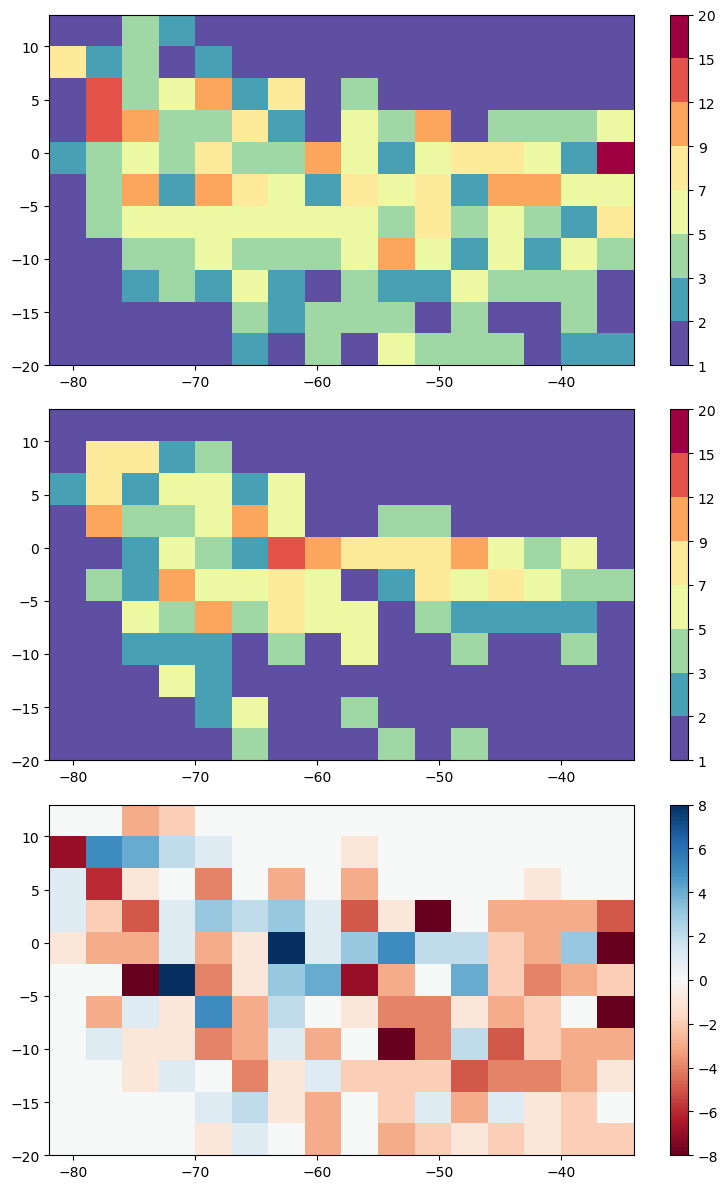

In [25]:
fig, ax = plt.subplots(nrows=3, figsize=[8,12], dpi=100)
levels = [1,2,3,5,7,9,12,15,20]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
mcs_initcount_diff = mcs_initcount_m1 - mcs_initcount_obs
pm1 = ax[0].pcolormesh(xbins_c, ybins_c, mcs_initcount_obs, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(xbins_c, ybins_c, mcs_initcount_m1, shading='auto', norm=norm, cmap=cmap)
pm3 = ax[2].pcolormesh(xbins_c, ybins_c, mcs_initcount_diff, shading='auto', vmin=-8, vmax=8, cmap='RdBu')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

In [26]:
mcs_initcount_diff.shape, xbins.shape, ybins.shape

((11, 16), (49,), (34,))

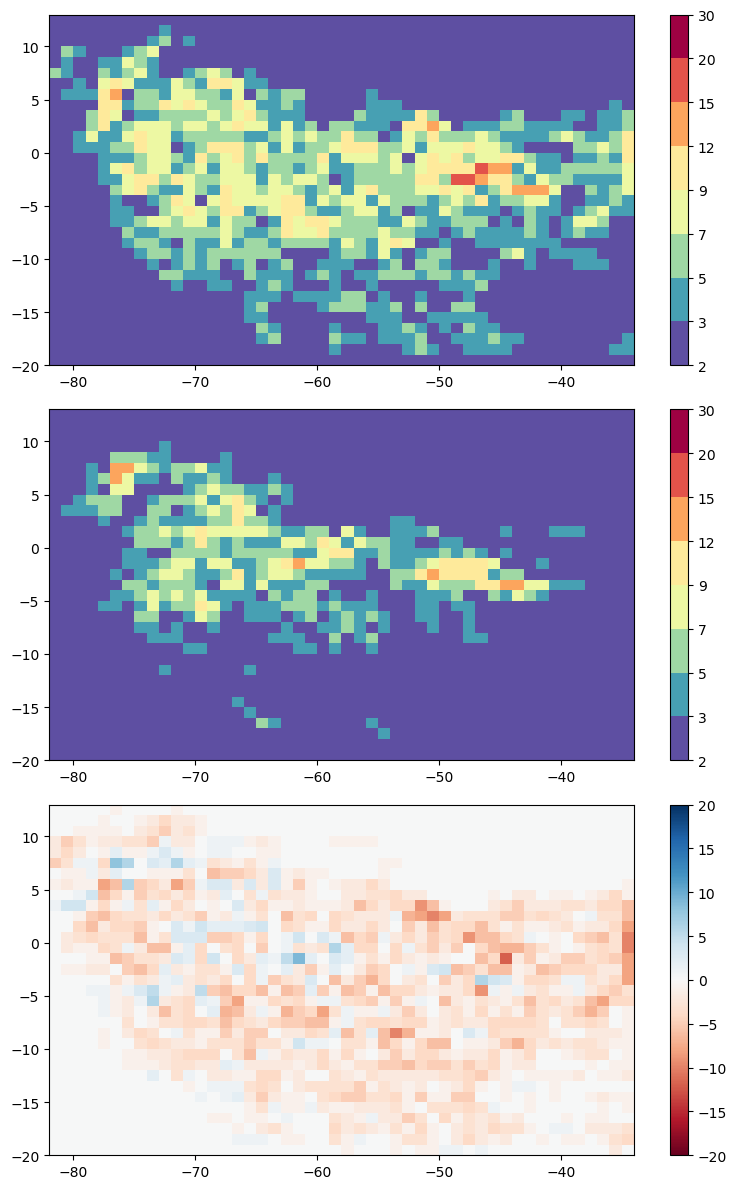

In [27]:
fig, ax = plt.subplots(nrows=3, figsize=[8,12], dpi=100)
levels = [2,3,5,7,9,12,15,20,30]
cmap = copy.copy(mpl.colormaps.get_cmap("Spectral_r"))
norm = mpl.colors.BoundaryNorm(boundaries=levels, ncolors=256)
mcs_irnumber_diff = mcs_irnumber_m1 - mcs_irnumber_obs
pm1 = ax[0].pcolormesh(xbins, ybins, mcs_irnumber_obs, shading='auto', norm=norm, cmap=cmap)
pm2 = ax[1].pcolormesh(xbins, ybins, mcs_irnumber_m1, shading='auto', norm=norm, cmap=cmap)
pm3 = ax[2].pcolormesh(xbins, ybins, mcs_irnumber_diff, shading='auto', vmin=-20, vmax=20, cmap='RdBu')
plt.colorbar(pm1, ax=ax[0])
plt.colorbar(pm2, ax=ax[1])
plt.colorbar(pm3, ax=ax[2])
fig.tight_layout()

In [28]:
def plot_map_mxn(nrows, ncols, dataarray, lonarray, latarray, levels, cmaps, titles, cblabels, cbticks, figname, oob_colors=None, figsize=None):
    
    mpl.rcParams['font.size'] = 12
    mpl.rcParams['font.family'] = 'Helvetica'

    map_extent = [-82, -34, -20, 13]
    lonv = np.arange(-80,-30.1,10)
    latv = np.arange(-20,10.1,10)
    proj = ccrs.PlateCarree()
    levelshgt = [1000,6000]
    resolution = '50m'
    land = cfeature.NaturalEarthFeature('physical', 'land', resolution)
    ocean = cfeature.NaturalEarthFeature('physical', 'ocean', resolution)
    borders = cfeature.NaturalEarthFeature('cultural', 'admin_0_boundary_lines_land', resolution)
    rivers = cfeature.NaturalEarthFeature(category='physical', name='rivers_lake_centerlines', scale=resolution)

    fig, axs = plt.subplots(nrows, ncols, figsize=figsize, dpi=100, subplot_kw=dict(projection=proj))
    
    for row in range(0, nrows):
        for col in range(0, ncols):
            ax = axs[row, col]
            ax.set_extent(map_extent, crs=proj)
            # ax.add_feature(borders, edgecolor='k', facecolor='none', linewidth=0.8, zorder=3)
            ax.add_feature(land, facecolor='none', edgecolor='k', lw=2, zorder=3)
            ax.add_feature(rivers, facecolor='none', edgecolor='k', zorder=3)
            ax.set_title(titles[row][col], loc='left')
            ax.set_aspect('auto', adjustable=None)
            ax.set_title(titles[row][col], loc='left')

            # Plot grid lines and lat/lon labels
            gl = ax.gridlines(crs=proj, draw_labels=False, linestyle='--', linewidth=0.5)
            gl.xlocator = mpl.ticker.FixedLocator(lonv)
            gl.ylocator = mpl.ticker.FixedLocator(latv)        
            ax.set_xticks(lonv, crs=ccrs.PlateCarree())
            lon_formatter = LongitudeFormatter(zero_direction_label=True)
            lat_formatter = LatitudeFormatter()        
            ax.xaxis.set_major_formatter(lon_formatter)
            ax.set_yticks(latv, crs=ccrs.PlateCarree())
            ax.yaxis.set_major_formatter(lat_formatter)            

            data = dataarray[row][col]
            Zm = np.ma.masked_where(((np.isnan(data))), data)
            cmap = copy.copy(mpl.colormaps.get_cmap(cmaps[row][col]))
            # Set out-of-bounds colors
            if (oob_colors is not None) and (row == 0):
                cmap.set_over(oob_colors['over'])
                cmap.set_under(oob_colors['under'])
            norm = mpl.colors.BoundaryNorm(boundaries=levels[row][col], ncolors=cmap.N)
            cf1 = ax.pcolormesh(lonarray, latarray, Zm, shading='auto', norm=norm, cmap=cmap, transform=proj, zorder=2)
            # if (oob_colors is not None) and (row != 0):
            #     cf1.cmap.set_over(oob_colors['over'])
            #     cf1.cmap.set_under(oob_colors['under'])
            #     cf1.set_clim(min(levels[row][col]), max(levels[row][col]))
            cb1 = plt.colorbar(cf1, ax=ax, label=cblabels[row][col], pad=0.02, ticks=cbticks[row][col], extend='both', aspect=30)

            # Terrain height
            ct = ax.contour(lon_ter, lat_ter, ter, levels=levelshgt, \
                            colors='dimgray', linewidths=1., transform=proj, zorder=3)

    # Work around to make tight_layout work 
    fig.canvas.draw()
    fig.tight_layout(w_pad=0.15)
    fig.savefig(figname, dpi=300, bbox_inches='tight', facecolor='w')
    return fig

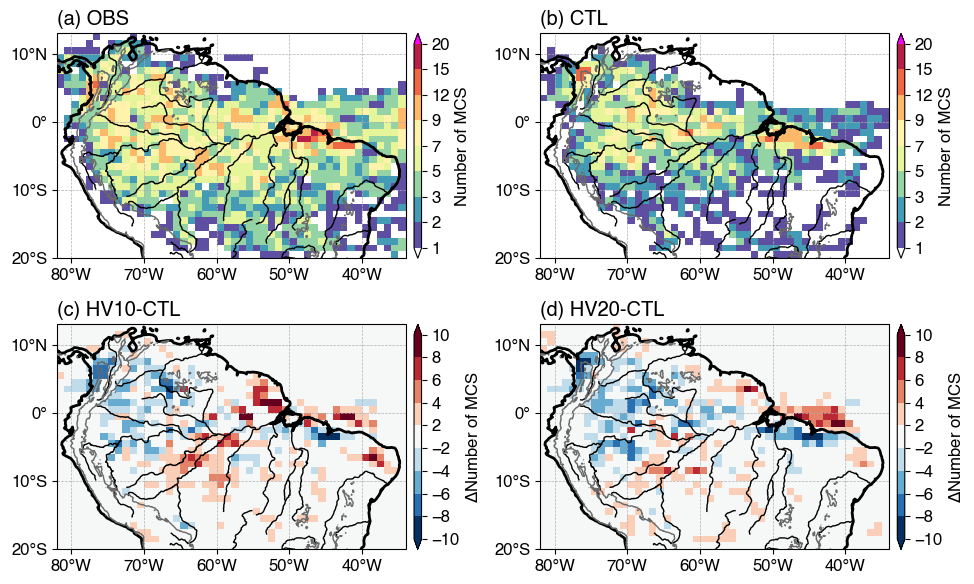

In [32]:
mcs_diff_m2_m1 = mcs_irnumber_m2 - mcs_irnumber_m1
mcs_diff_m3_m1 = mcs_irnumber_m3 - mcs_irnumber_m1
dataarray = [
    [mcs_irnumber_obs, mcs_irnumber_m1], 
    [mcs_diff_m2_m1, mcs_diff_m3_m1],
]
levels = [1,2,3,5,7,9,12,15,20]
levelsdiff = np.arange(-10,10.1,2)
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS', f'(b) CTL'], [f'(c) HV10-CTL', f'(d) HV20-CTL']]
cblabels = [['Number of MCS','Number of MCS'],[r'$\Delta$'+'Number of MCS',r'$\Delta$'+'Number of MCS']]
cbticks = levels
figname = f'{figdir}mcs_irnumber_map_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_mxn(2, 2, dataarray, xbins, ybins, levels, cmaps, titles, cblabels, cbticks, figname, figsize=[10,6], oob_colors=oob_colors)

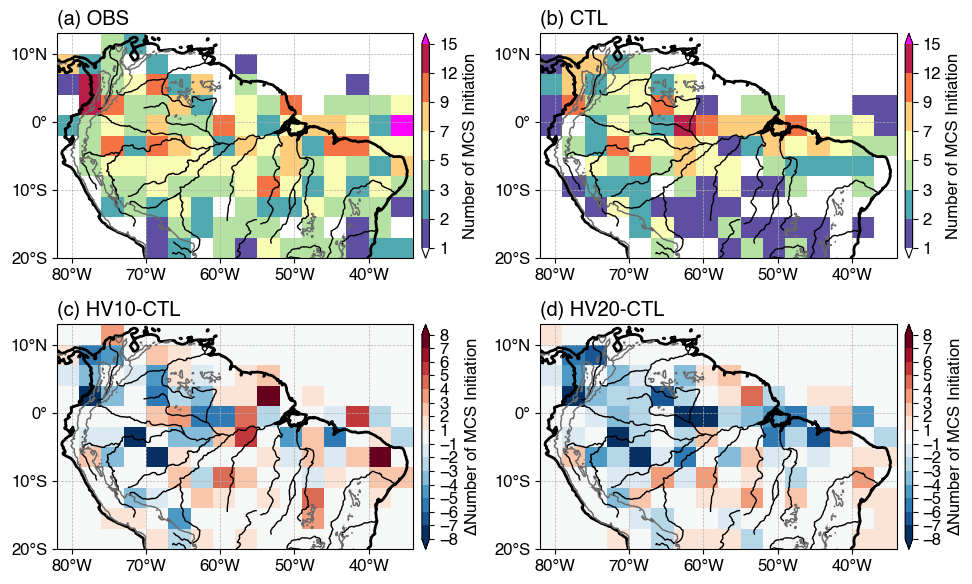

In [33]:
mcs_initcount_diff_m2_m1 = mcs_initcount_m2 - mcs_initcount_m1
mcs_initcount_diff_m3_m1 = mcs_initcount_m3 - mcs_initcount_m1
dataarray = [
    [mcs_initcount_obs, mcs_initcount_m1], 
    [mcs_initcount_diff_m2_m1, mcs_initcount_diff_m3_m1]
]
levels = [1,2,3,5,7,9,12,15]
levelsdiff = np.arange(-8,8.1,1)
# levelsdiff = [-20,-16,-12,-8,-6,-4,-2,0,2,4,6,8,12,16,20]
# Remove mid-point (0 value)
idx = int((len(levelsdiff)-1)/2)
levelsdiff = np.delete(levelsdiff, idx)
levels = [[levels, levels], [levelsdiff,levelsdiff]]
cmap = copy.copy(mpl.colormaps.get_cmap('Spectral_r'))
cmap = truncate_colormap(cmap, 0.0, 0.95)
cmapdiff = copy.copy(mpl.colormaps.get_cmap('RdBu_r'))
cmaps = [[cmap,cmap], [cmapdiff,cmapdiff]]
titles = [[f'(a) OBS', f'(b) CTL'], [f'(c) HV10-CTL', f'(d) HV20-CTL']]
cblabels = [['Number of MCS Initiation','Number of MCS Initiation'],[r'$\Delta$'+'Number of MCS Initiation',r'$\Delta$'+'Number of MCS Initiation']]
cbticks = levels
figname = f'{figdir}mcs_initiation_map_obs_ctl_hv10_hv20.png'
oob_colors = {'under':'white', 'over':'magenta'}
fig = plot_map_mxn(2, 2, dataarray, xbins_c, ybins_c, levels, cmaps, titles, cblabels, cbticks, figname, figsize=[10,6], oob_colors=oob_colors)

In [31]:
figdir

'/global/cfs/cdirs/m1657/zfeng/amazon_hvmixing/figures/'